# 4주차 Regularization

<img src='https://d2l.ai/_images/dropout2.svg'>

## 4.1 Initialization

적절한 가중치 초기화는 gradient vanishing 문제 및 exploding gradient 문제를 해소하는 데 도움을 줍니다.

반면 적절하지 못한 가중치 초기화는 모델 학습에 큰 장해가 되며, 모델의 다양성을 확보하지 못하도록 할 수 있습니다.


**Xavier Normal Initialization**

일반적으로는 sigmoid 활성화 함수를 사용할 때 자주 병용되는 것으로 알려져 있습니다.

$$ W\sim\mathcal{N}\left(0,\sqrt{2\over n_{in}+n_{out}}^2 \right) $$

* Pytorch 에서는 **torch.nn.init.xavier_uniform_**으로 구현되어 있습니다!

**He Normal Initialization**

이는 ReLU 활성화 함수를 사용할 때 많이 활용됩니다.

$$ W\sim\mathcal N\left(0,\sqrt{2\over n_{in}}^2\right) $$

* Pytorch 로는 **torch.nn.init.kaiming_normal_** 을 통해 구현되어 있습니다!

## 4.2 Dropout

딥러닝 모델의 학습 과정에서 일정 확률로 일부 노드의 값을 0으로 처리하여 모델의 다양성을 제고하는 기법입니다.

Standard dropout regularization 은 *dropout probability* $p$ 를 정하고, 중간 레이어의 활성화함수 $\sigma$ 를 다음과 같이 확률변수 $\sigma'$로 변형하여 구현합니다.

$$ \sigma'=\begin{cases}0&\text{w.p. }p\\{\sigma\over 1-p}&\text{otherwise}  \end{cases} $$

이때 기댓값은 바뀌지 않아야 함을 명심해주세요!

$$ \mathbb{E}[ \sigma ']=\sigma $$

In [1]:
!pip install --quiet d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
      return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [6]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

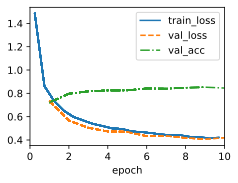

In [7]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}

model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

* Pytorch에서는 **nn.Dropout(p_val)** 로 구현됩니다!

*class DropoutModel* 의 어느 위치에 dropout 코드가 들어가는지 잘 살펴봐주세요.

In [25]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [26]:
# CUDA device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [27]:
# MNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [28]:
# Train dataset 과 Train DataLoader
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test dataset 과 Test DataLoader
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [29]:
# 가중치 초기화 함수
def initialize_weights(model, init_type='xavier'):
    if init_type == 'xavier':
        initializer = nn.init.xavier_uniform_
    elif init_type == 'he':
        initializer = nn.init.kaiming_normal_
    else:
        raise ValueError("Unsupported initialization type: choose 'xavier' or 'he'")

    for m in model.modules():
        if isinstance(m, nn.Linear):
            initializer(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [30]:
# DropoutModel 정의
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.layer1 = nn.Linear(784, 1200)
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(1200, 1200)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(1200, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

In [31]:
# 모델, 가중치, 손실 함수 및 옵티마이저 초기화
model = DropoutModel().to(device)
initialize_weights(model, init_type='xavier')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# 모델 학습 함수
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)  # 데이터를 CUDA 장치로 이동
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Update progress bar with current loss
        if batch_idx % 100 == 99:  # Update every 100 batches
            progress_bar.set_postfix(loss=running_loss / 100)
            running_loss = 0.0

In [33]:
# 모델 평가 함수
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)  # 데이터를 CUDA 장치로 이동
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    tqdm.write(f'Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')


In [34]:
# 학습 및 평가
num_epochs = 10
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    test(model, test_loader, criterion)

Average loss: 0.0002, Accuracy: 9412/10000 (94.12%)


Average loss: 0.0002, Accuracy: 9478/10000 (94.78%)


Average loss: 0.0001, Accuracy: 9575/10000 (95.75%)


Average loss: 0.0001, Accuracy: 9605/10000 (96.05%)


Average loss: 0.0001, Accuracy: 9619/10000 (96.19%)


Average loss: 0.0002, Accuracy: 9535/10000 (95.35%)


Average loss: 0.0001, Accuracy: 9686/10000 (96.86%)


Average loss: 0.0001, Accuracy: 9666/10000 (96.66%)


Average loss: 0.0001, Accuracy: 9683/10000 (96.83%)


Average loss: 0.0001, Accuracy: 9685/10000 (96.85%)


## 4.3 Batch Normalization

<img src='https://media.licdn.com/dms/image/C4D12AQHDXT208VWD6w/article-inline_image-shrink_400_744/0/1578308402159?e=1726099200&v=beta&t=QHgJ37nsqzSoXi7muOs2zKjKfb4V6JH1tWfmDxQDS9w'>

깊은 레이어를 가지는 딥러닝 모델에서는 **Internal Covariate shift** 현상이 발생하기 쉽습니다.

Batch Normalization 은 위 현상을 줄임으로써,

* 더 높은 학습률 값 사용,
* Saturating nonlinearities 허용,
* 덜 민감한 초기값 설정

을 가능하게 합니다.


Batch Normalization 관련하여는 이후 5주차 CNN 에서 코드와 함께 다루도록 하겠습니다!



# [4주차 과제]

아래의 논문을 팀별로 읽고 리뷰페이퍼를 작성해주세요!

### Y, Bengio et al., *Practical recommendations for gradient-based training of deep architectures*., 2012. <a href='https://arxiv.org/abs/1206.5533'>[arXiv link]</a>

---

* 위 논문의 **Chapter 3 (Hyper-parameters)(pp. 7-21)** 부분을 리뷰해주시면 됩니다!

* 팀별로 자유롭게 토의 및 정리 후, 각 팀당 **하나의 페이퍼**를 작성해주시면 됩니다.

* 기한은 2024. 7. 31. (수) 22:00 까지로, 결과물을 Github 과제 제출란에 업로드 해주세요.

* 파일 형식은 자유롭게 설정하여 진행하시되, 최종 결과물의 깨짐 현상을 막기 위해서 가급적 pdf로 변환해 제출해주시면 감사하겠습니다. :)

* 최종 파일명은 $\text{"DL_팀명_4주차"}$ 으로 제출해주세요!